<h2>Machine learning for Stocks Trading</h2>

Step1. Getting historical data.

Libraries or Modules:

Yahoo Finance module.
Create charts
handle dataframes -pandas 
we need to determine functions


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, time


#Install Yahoo Finance libraries
try:
    import yfinance
    
except:
    !pip install -q yfinance
    import yfinance
    
try:
    import yahoofinancials
    
except:
    !pip install -q yahoofinancials
    import yahoofinancials
    


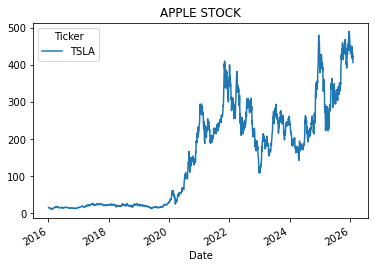

In [28]:
import yfinance as yf
from yahoofinancials import YahooFinancials
import warnings
warnings.filterwarnings("ignore")

#download historical data #AAPL
df = yf. download('TSLA',
                 start= '2016-01-01',
                 end = date.today(),
                 progress= False)
#create a simple chart

df.plot(y='Close', title = 'APPLE STOCK')
plt.show()
    

Creating Technical Analysis Indicators and we are going to also plot them

In [29]:
!pip install ta


In [30]:
print(df.columns)

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])


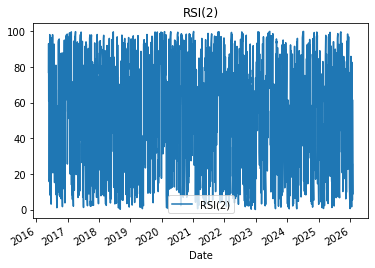

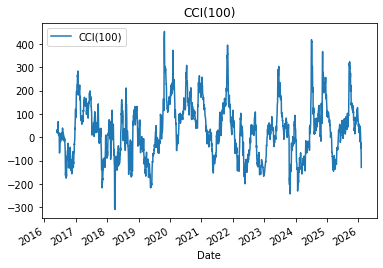

Price           Close       High        Low       Open    Volume     RSI(2)  \
Date                                                                          
2016-05-25  14.638667  14.757333  14.434000  14.527333  46902000  77.019272   
2016-05-26  15.008000  15.017333  14.603333  14.700000  61086000  93.165824   
2016-05-27  14.869333  15.062000  14.716667  14.999333  54754500  60.988546   
2016-05-31  14.882000  14.983333  14.766667  14.869333  41835000  63.303976   
2016-06-01  14.637333  14.826667  14.459333  14.765333  44740500  19.224494   

Price          RSI(7)    RSI(14)    CCI(30)    CCI(50)   CCI(100)  
Date                                                               
2016-05-25  56.467880  47.379654 -40.624898 -63.636941  21.008380  
2016-05-26  66.017791  52.811341 -22.518691 -46.451776  32.616715  
2016-05-27  60.230105  50.695467 -19.162804 -45.768479  32.905079  
2016-05-31  60.598231  50.889027 -16.160446 -44.853010  32.465602  
2016-06-01  50.139464  47.047022 -29.2

In [31]:
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import CCIIndicator

# ===== Flatten MultiIndex (if any) =====
if isinstance(df.columns, pd.MultiIndex):
    # Select only AAPL ticker columns
    df = df.xs('TSLA', axis=1, level=1)

# Make sure numeric
df['Close'] = df['Close'].astype(float)
df['High'] = df['High'].astype(float)
df['Low'] = df['Low'].astype(float)

# ===== Calculate Indicators =====

# RSI
df['RSI(2)'] = RSIIndicator(df['Close'], window=2).rsi()
df['RSI(7)'] = RSIIndicator(df['Close'], window=7).rsi()
df['RSI(14)'] = RSIIndicator(df['Close'], window=14).rsi()

# CCI
df['CCI(30)'] = CCIIndicator(df['High'], df['Low'], df['Close'], window=30).cci()
df['CCI(50)'] = CCIIndicator(df['High'], df['Low'], df['Close'], window=50).cci()
df['CCI(100)'] = CCIIndicator(df['High'], df['Low'], df['Close'], window=100).cci()

# Drop NaN rows
df.dropna(inplace=True)

# ===== Plot indicators =====
df.plot(y='RSI(2)', title='RSI(2)')
plt.show()

df.plot(y='CCI(100)', title='CCI(100)')
plt.show()

# Check first few rows
print(df.head())




Prepare our data labelling

what do we want to do over here?

when we place our trade : Buy at open(over the next day).
we want to close our trade : at the next day at open.

formula:

Handling the returns this ways:Open(-1) - Closing: Open(-2)

we want to label our data in the following  day.

Buy SIGNAL : Open(-2) > Open(-1)

Sell SIGNAL : Open(-2) < Open(-1)

Indicators the current situations, and our labels take a look ahead of time to determine if we have a pattern.

In [32]:
import numpy as np
df['LABEL'] = np.where(df['Open'].shift(-2).gt(df['Open'].shift(-1)), "1", "0")
df = df.dropna()
df.head()

Price,Close,High,Low,Open,Volume,RSI(2),RSI(7),RSI(14),CCI(30),CCI(50),CCI(100),LABEL
Date,,,,,,,,,,,,
2016-05-25,14.638667,14.757333,14.434000,14.527333,46902000,77.019272,56.467880,47.379654,-40.624898,-63.636941,21.008380,1
2016-05-26,15.008000,15.017333,14.603333,14.700000,61086000,93.165824,66.017791,52.811341,-22.518691,-46.451776,32.616715,0
2016-05-27,14.869333,15.062000,14.716667,14.999333,54754500,60.988546,60.230105,50.695467,-19.162804,-45.768479,32.905079,0
2016-05-31,14.882000,14.983333,14.766667,14.869333,41835000,63.303976,60.598231,50.889027,-16.160446,-44.853010,32.465602,0
2016-06-01,14.637333,14.826667,14.459333,14.765333,44740500,19.224494,50.139464,47.047022,-29.226941,-58.044859,22.092727,1


Creating Neural Network

In [33]:
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score

#fitting- indicators and our labelling
x= df[df.columns[6:-1]].values
y = df['LABEL'].values

x_train,x_test, y_train, y_test= train_test_split(x,y,test_size=0.3)
mlp = MLPClassifier(hidden_layer_sizes=(8,8,8), activation ='relu', solver='adam',max_iter=1000)
mlp.fit(x_train, y_train)

predict_train = mlp.predict(x_train)
predict_test = mlp.predict(x_test)

from sklearn.metrics import classification_report, confusion_matrix

print('Train data Accuracy ')

print(classification_report(y_train,predict_train))

print('Test data Accuracy ')
print(classification_report(y_test,predict_test))

Train data Accuracy 
              precision    recall  f1-score   support

           0       0.59      0.17      0.27       848
           1       0.52      0.88      0.65       858

    accuracy                           0.53      1706
   macro avg       0.55      0.53      0.46      1706
weighted avg       0.55      0.53      0.46      1706

Test data Accuracy 
              precision    recall  f1-score   support

           0       0.53      0.14      0.22       355
           1       0.52      0.89      0.66       377

    accuracy                           0.52       732
   macro avg       0.53      0.51      0.44       732
weighted avg       0.53      0.52      0.44       732



Backtesting our model
Measure the returns obtained by trading our model

[]

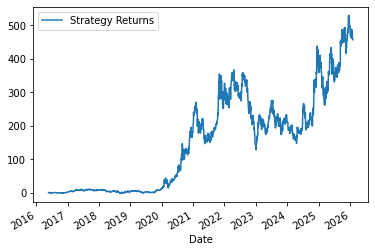

In [34]:
df['Prediction'] = np.append(predict_train, predict_test)
df['Strategy Returns']= np.where(df['Prediction'].eq("1"),df['Open'].shift(-2)-df['Open'].shift(-1),0)

df['Strategy Returns'] =  df['Strategy Returns'].cumsum()
df.plot(y='Strategy Returns')
plt.plot()

In [35]:
prediction = df.iloc[-1]['Prediction']

if prediction=="1":
    print("today's return forecast : UP")
else:
    print("today's return forecast : DOWN")

today's return forecast : UP
